# Chap3 평가
분류의 성능 평가 지표
- 정확도
- 오차행렬
- 정밀도
- 재현율
- F1 스코어
- ROC AUC

분류
- 긍정/부정, 0/1과 같은 2개의 결괏값만을 가지는 이진 분류
- 여러 개의 결정 클래스 값을 가지는 멀티 분류

### 정확도
- 실제 데이터에서 예측 데이터가 얼마나 같은지
- 이진 분류의 경우 데이터 구성에 따라 ML 모델의 성능 왜곡할 수 있음

In [5]:
# BaseEstimator 클래스 상속받아 학습X 성별에 따라 생존자 예측하는 단순한 Classifier 생성
# BaseEstimator를 상속받으면 Customized 형태의 Estimator을 개발자가 생성가능

from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator):
    #fit() 메서드는 아무것도 학습X
    def fit(self, X, y=None):
        pass
    #predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i]==1:
                pred[i]=0
            else:
                pred[i]=1
                
        return pred

In [6]:
# 지금까지 피처를 가공한 내역 정리하고 이를 함수로 만들어 쉽게 재사용할 수 있도록 만듦
# 데이터 전처리를 전체적으로 호출하는 함수는 transform_features()이며 Null 처리, 포매팅, 인코딩을 수행
from sklearn import preprocessing

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩
def format_features(df):
    df['Cabin']=df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 로딩, 가공, 분할
titanic_df = pd.read_csv('train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 학습/예측/평가
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypred = myclf.predict(X_test)
print('정확도는:{0:.4f}'.format(accuracy_score(y_test, mypred)))

정확도는:0.7877


단순한 알고리즘으로 예측을 하더라도 데이터의 구성에 따라 정확도 결과가 약 78.77%로 높게 나옴    

- 정확도는 불균형한 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아님

MNIST 데이터 세트를 변환해 불균형한 데이터 세트를 만들어보자!    
* MNIST : 0~9 숫자 이미지 픽셀 정보
- 레이블 값이 7인 것만 True, 나머지 값은 모두 False로 변환해 이진 분류 문제로 바꿈
- 즉 전체 10%만 True인 불균형한 데이터 세트로

In [8]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 변환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

digits = load_digits()

# digits 번호가 7번이면 True고 이를 astype(int)로 1로 변환
y = (digits.target ==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [9]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 : ', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 :  (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


모든 predict()의 결과를 0으로 변환함에도 불구하고 정확도는 90%    
- 불균형한 레이블 데이터 세트에서 정확도 평가 지표는 성능 수치로 사용돼서는 X
- 한계점 극복 위해 다른 분류 지표와 함께 사용해야 함

### 오차 행렬
- 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지

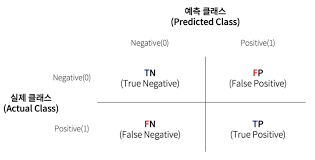

- TN : 예측값 0, 실제 값 0
- FP : 예측값 1, 실제 값 0
- FN : 예측값 0, 실제 값 1
- TP : 예측값 1, 실제 값 1    
(Negative = 0, Positive = 1)    

    
- confusion_matrix() 사용

In [10]:
# 위 정확도에서의 예제인 MyFakeClassifier의 예측 성능 지표를 오차 행렬로 표현
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

- ndarray 형태
- TN:405, FP:0, FN:45, TP:0

- 정확도=(TN+TP)/(TN+FP+FN+TP)
- 이진 분류 모델은 많은 데이터 중에서 중점적으로 찾아야 하는 매우 적은 수의 결괏값에 1을 부여하고 그렇지 않은 경우 0을 부여하는 경우가 많음
- ex) 사기 행위 예측 모델:사기 행위 1, 정상 행위:0
- Positive 데이터 건수가 매우 작기 때문에 데이터에 기반한 ML 알고리즘이 Negative로 예측 정확도가 높아지는 경향 발생
- TN 매우 커지고 TP 매우 작아짐, FN 매우 작고 FP도 매우 작음

### 정밀도와 재현율
- Positive 데이터 세트의 예측 성능에 초점
- 정밀도=TP/(FP+TP) : 예측을 Positive로 한 대상 중(분모)에 예측과 실제 값이 Positive로 일치한 데이터(분자) 비율
- 재현율=TP/(FN+TP) : 실제 값이 Positive인 대상 중(분모)에 예측과 실제 값이 Positive로 일치한 데이터(분자) 비율, 민감도, TPR    
<br>    
- 재현율이 중요 지표인 경우 = 실제 Positve 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우    
ex) 암 판단 모델, 금융 사기 적발 모델
- 정밀도가 더 중요한 지표인 경우 = 실제 Negative 음성 데이터를 Positive로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우    
ex) 스팸메일 여부 판단 모델    
<br>   
- 모두 TP를 높이는 데 초점을 맞추지만 재현율은 FN을 낮추는 데, 정밀도는 FP를 낮추는 데 초점

In [56]:
# 정확도, 재현율, 정밀도, 오차 행렬 한꺼번에 호출하는 함수 만들기
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)  #오차행렬
    accuracy = accuracy_score(y_test, pred)     #정확도
    precision = precision_score(y_test, pred)   #정밀도
    recall = recall_score(y_test, pred)         #재현율
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [16]:
# 로지스틱 회귀 기반으로 타이타닉 생존자 예측 + 이것저것 평가 수행

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 데이터 로딩, 가공, 분할
titanic_df = pd.read_csv('train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)
lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


C:\Users\jiddo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 정밀도/재현율 트레이드오프
- 업무 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 수치 높일 수 있음
- but 정밀도와 재현율은 상호 보완적인 평가 지표이므로 한쪽을 강제로 높이면 다른 하나는 떨어짐    
<br>    
- 사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블에 속하는지 계산하기 위해 개별 레이블별로 결정 확률 구함
- 예측 확률이 큰 레이블값으로 예측
- 일반적인 이진 분류에서는 임곗값을 0.5로 정하고 이보다 확률이 크면 Positive, 작으면 Negative로 결정    
<br>    
- predict_proba() : 개별 데이터별로 예측 확률 반환, 학습이 완료된 사이킷런 Classifier 객체에서 호출 가능, 테스트 피처 데이터 세트를 파라미터로 입력, 테스트 피처 레코드의 개별 클래스 예측 확률 반환

In [18]:
# predict_proba()와 predict() 결과 비교
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape:{0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 추출\n', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shape:(179, 2)
pred_proba array에서 앞 3개만 추출
 [[0.4616653  0.5383347 ]
 [0.87862763 0.12137237]
 [0.87727002 0.12272998]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.4616653  0.5383347  1.        ]
 [0.87862763 0.12137237 0.        ]
 [0.87727002 0.12272998 0.        ]]


- 첫 번째 칼럼 값 + 두 번째 칼럼 값 = 1
- 두 개의 칼럼 중 더 큰 확률 값으로 predict() 메서드가 최종 예측    
<br>    
- predict()는 predict_proba()메서드 기반해 생성된 API
- predict()는 predict_proba() 호출 결과로 반환된 배열에서 분류 결정 임계값보다 큰 값이 들어 있는 칼럼 위치 받아 최종적으로 예측 클래스 결정

#### 사이킷런의 정밀도/재현율 트레이드오프 방식 이해하기
- Binarizer 클래스 이용
- threshold 변수 특정 값으로 설정하고 Binarizer 객체 생성 후 fit_transform() 메서드를 이용해 ndarray 입력하면 입력된 ndarray의 값을 지정된 threshold보다 같거나 작으면 0으로 크면 1로 변환해 반환

In [19]:
from sklearn.preprocessing import Binarizer
X=[[1, -1, 2], [2, 0, 0], [0, 1.1, 1.2]]

binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [20]:
# 앞 예제의 LogisticRegression의 pred_proba 객체 변수에 Binarizer 적용해 최종 예측값 구하기
custom_threshold=0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer 적용
pred_proba_1 = pred_proba[:,1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [21]:
# 만약 분류 결정 임곗값을 0.4로 한다면!
custom_threshold=0.4

pred_proba_1 = pred_proba[:,1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361


임곗값↓ = 정밀도↓ 재현율↑

- 분류 결정 임곗값은 Positive 예측값 결정하는 확률 기준
- 0.4인 경우 0.4부터 Positive로 예측을 너그럽게 하기 때문에 임곗값 낮출수록 True 많아짐
- 따라서 Positive 예측값이 많아지므로 상대적으로 재현율 값 증가
- 양성 예측을 많이 하다보니 실제 양성을 음성으로 예측하는 횟수가 상대적으로 감소

In [57]:
# 임곗값 0.4부터 0.6까지 0.05씩 증가시키며 평가 지표 조사
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('\n임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1, 1), thresholds)


임곗값: 0.4
오차행렬
[[80 20]
 [17 37]]
정확도: 0.7597, 정밀도: 0.6491, 재현율: 0.6852

임곗값: 0.45
오차행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667

임곗값: 0.5
오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111

임곗값: 0.55
오차행렬
[[91  9]
 [23 31]]
정확도: 0.7922, 정밀도: 0.7750, 재현율: 0.5741

임곗값: 0.6
오차행렬
[[91  9]
 [26 28]]
정확도: 0.7727, 정밀도: 0.7568, 재현율: 0.5185


precision_recall_curve() 제공    
- 입력파라미터
    - y_true : 실제 클래스값 배열
    - probas_pred : Positive 칼럼의 예측 확률 배열

- 반환 값
    - 정밀도 : 임곗값별 정밀도 값 배열로
    - 재현율 : 임곘값별 재현율 값 배열로
    - 0.11~0.95 정도의 임곗값을 담은 ndarray

In [25]:
# precision_recall_curve() 이용해 타이타닉 예측 모델의 임곗값별 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)    # 0부터 147까지 15씩 증가
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index], 2))

#15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값: [0.1  0.12 0.14 0.19 0.28 0.4  0.57 0.67 0.82 0.95]
샘플 임계값별 정밀도: [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율: [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


임곗값↑ = 정밀도↑ 재현율↓

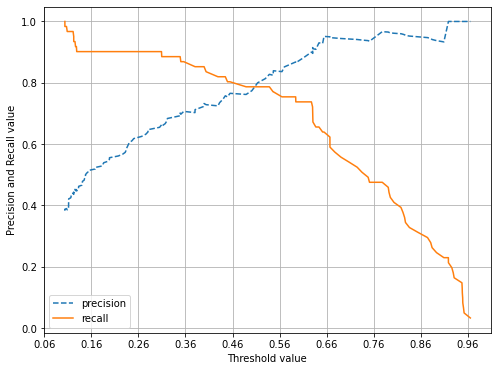

In [28]:
# 정밀도 재현율 곡선 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축:threshold값, Y축:정밀도, 재현율, 정밀도:점선
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()    # x축 범위
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))    #눈금
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()    #범례, 격자
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

### F1 스코어
- 정밀도와 재현율을 결합한 지표
- 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값
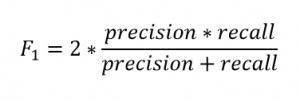
- f1_score()

In [29]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어:{0:.4f}'.format(f1))

F1 스코어:0.7805


In [62]:
# 타이타닉 생존자 예측에서 임곗값 변화시키면서 F1 스코어 포함한 평가 지표 구하기
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)  #오차행렬
    accuracy = accuracy_score(y_test, pred)     #정확도
    precision = precision_score(y_test, pred)   #정밀도
    recall = recall_score(y_test, pred)         #재현율
    f1 = f1_score(y_test, pred)                 #F1 스코어
    
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1, 1), thresholds)


임곗값: 0.4
오차행렬
[[80 20]
 [17 37]]
정확도: 0.7597, 정밀도: 0.6491, 재현율: 0.6852, F1: 0.6667

임곗값: 0.45
오차행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667, F1: 0.6857

임곗값: 0.5
오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804

임곗값: 0.55
오차행렬
[[91  9]
 [23 31]]
정확도: 0.7922, 정밀도: 0.7750, 재현율: 0.5741, F1: 0.6596

임곗값: 0.6
오차행렬
[[91  9]
 [26 28]]
정확도: 0.7727, 정밀도: 0.7568, 재현율: 0.5185, F1: 0.6154


### ROC 곡선과 AUC
- ROC 곡선 : FPR이 변할 때 TPR(재현율)이 어떻게 변하는지    
<br>    
- 민감도(TPR, 재현율): 실제값 Positive가 정확히 예측돼야 하는 수준
- 특이성(TNR): 실제값 Negative가 정확히 예측돼야 하는 수준
- FPR = FP/(FP+TN) = 1-TNR = 1-특이성
- ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어짐, 멀어질수록 성능 뛰어남    
<br>    
- roc_curve()    
- 입력 파라미터
    - y_true:실제 클래스 값 array
    - y_score: predict_proba()의 반환 값 array에서 Positive 칼럼 예측 확률 
- 반환 값
    - fpr
    - tpr
    - thresholds

In [59]:
from sklearn.metrics import roc_curve, roc_auc_score

#레이블 값이 1일 때의 예측 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index], 2))

print('샘플 임곗값별 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46]
샘플용 10개의 임곗값: [0.98 0.78 0.63 0.48 0.39 0.35 0.3  0.24 0.17 0.11]
샘플 임곗값별 FPR: [0.01 0.03 0.08 0.12 0.21 0.26 0.35 0.4  0.52 0.7 ]
샘플 임곗값별 TPR: [0.    0.278 0.5   0.648 0.685 0.741 0.796 0.852 0.926 1.   ]


임곗값이 1에 가까운 값에서 점점 작아지면서 FPR↑, FPR이 조금씩 커질 때 TPR은 가파르게 커짐

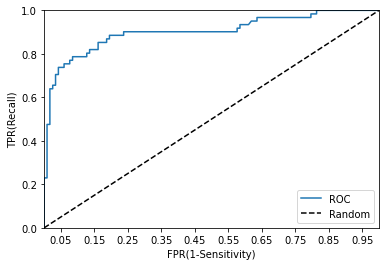

In [32]:
# FPR의 변화에 따른 TPR의 변화 ROC 곡선으로 시각화
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label='ROC')
    #가운데 대각선 직선 그림
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    start, end = plt.xlim()    # x축 범위
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))    #눈금
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

- AUC(Area Under Curve) : ROC 곡선 밑의 면적 구한 것으로 1에 가까울수록 좋은 수치
- AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건
- 가운데 직선에서 멀어지고 왼쪽 상단 모서리 쪽으로 가파르게 곡선이 이동할수록 좋은 성능 수치

In [60]:
# 타이타닉 생존자 예측에서 ROC AUC값 포함한 평가 지표 구하기
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)  #오차행렬
    accuracy = accuracy_score(y_test, pred)     #정확도
    precision = precision_score(y_test, pred)   #정밀도
    recall = recall_score(y_test, pred)         #재현율
    f1 = f1_score(y_test, pred)                 #F1 스코어
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

### 피마 인디언 당뇨병 예측
- 당뇨병 여부 판단하는 머신러닝 예측 모델 수립 + 평가 지표 적용
- 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


전체 768개 데이터 중 Negative값 500개, Positive값 268개

In [37]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- NULL 값 X
- 피처 타입 모두 숫자형    
⇒ 별도의 피처 인코딩 필요X

In [38]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
# 맨 끝이 Outcome 칼럼으로 레이블 값임. 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도: 0.7209, 재현율: 0.5741, F1: 0.6392, AUC: 0.7919


C:\Users\jiddo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


전체 데이터의 65%가 Negative이므로 정확도보다는 재현율 성능에 좀 더 초점을 맞추자!    
    
정밀도 재현율 곡선을 보고 임곗값별 정밀도와 재현율 값 변화 확인

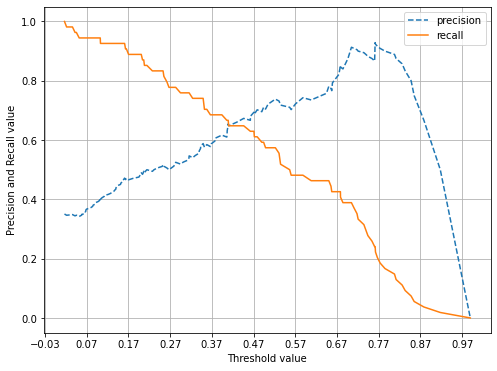

In [39]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

임곗값을 0.42정도로 하면 정밀도와 재현율의 균형 맞출 수 있을 것    
하지만 두 지표 모두 0.7이 안 되는 수치로 값이 낮다.    
    
데이터 점검을 해보자!

In [40]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


min()값이 0으로 되어있는 피처가 상당히 많다.    
min() 값이 0으로 돼 있는 피처에 대해 0 값의 건수 및 전체 데이터 건수 대비 몇 퍼센트의 비율로 존재하는지 확인

In [41]:
# 0값을 검사할 피처 명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수 추출 후 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}. 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5. 퍼센트는 0.65 %
BloodPressure 0 건수는 35. 퍼센트는 4.56 %
SkinThickness 0 건수는 227. 퍼센트는 29.56 %
Insulin 0 건수는 374. 퍼센트는 48.70 %
BMI 0 건수는 11. 퍼센트는 1.43 %


SkinThickness와 Insulin의 0 값은 29.56%와 48.7%로 상당히 많음    
- 이를 삭제할 경우 전체 데이터 건수가 많지 않기 때문에 학습 효과적으로 수행하기 어려움
- 0값을 평균값으로 대체

In [42]:
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)

In [50]:
# 피처 스케일링 적용
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

# 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC: 0.8433


In [63]:
# 결정 임곗값 변화시키면서 재현율 값의 성능 수치 확인
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1, 1), thresholds)


임곗값: 0.3
오차행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963, F1: 0.6615

임곗값: 0.33
오차행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778, F1: 0.6774

임곗값: 0.36
오차행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222, F1: 0.6667

임곗값: 0.39
오차행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037, F1: 0.6667

임곗값: 0.42
오차행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667, F1: 0.6792

임곗값: 0.45
오차행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667, F1: 0.6857

임곗값: 0.48
오차행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.6931

임곗값: 0.5
오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804


In [48]:
# 임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict)proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.6931, AUC: 0.8433
